In [1]:
%load_ext autoreload
%autoreload 2

import os
from datetime import datetime
from functools import partial
from pathlib import Path, PurePath
from random import shuffle
import imagesize

from torch.utils.data import DataLoader
import segmentation_models_pytorch as smp
import torch
from pytorch_lightning import Trainer
from rasterio.windows import Window

from dl_toolbox.callbacks import MergePreds
import dl_toolbox.datamodules as datamodules
import dl_toolbox.modules as modules
from dl_toolbox.transforms import NoOp
from dl_toolbox.datasets import FlairTiled
from dl_toolbox.utils import CustomCollate

/d/pfournie/dl_toolbox/venv/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
module = modules.Multilabel(
    network=partial(smp.Unet, encoder_name="efficientnet-b0"),
    optimizer=None,
    scheduler=None,
    class_weights=[1.]*13,
    in_channels=3,
    num_classes=13,
)

In [6]:
img_path = '/data/flair_merged/train/D004_2021/IMG_Z10_AU.tif'
label_path = '/data/flair_merged/train/D004_2021/MSK_Z10_AU.tif'
w, h = imagesize.get(img_path)
window = Window(0, 0, w, h)

dataset = FlairTiled(
    img_path=img_path,
    label_path=label_path,
    window=window,
    bands=[1,2,3],
    merge='main13',
    crop_size=1024,
    crop_step=512,
    transforms=NoOp()
)

dataloader = DataLoader(
    dataset=dataset,
    shuffle=False,
    collate_fn=CustomCollate(),
    batch_size=8,
    num_workers=6
)    

In [4]:
log_dir = Path('/data/outputs/flair/lightning_logs/23Jul23-11h11m48')

merger = MergePreds(window)

trainer = Trainer(
    accelerator='gpu',
    devices=1,
    logger=False,
    callbacks=[merger]
)

logits = trainer.predict(
    model=module,
    dataloaders=dataloader,
    return_predictions=True,
    ckpt_path=log_dir/'checkpoints/epoch_epoch=018.ckpt'
)

confs, preds = module.probas2confpreds(merger.merged.unsqueeze(dim=0))

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
Restoring states from the checkpoint path at /data/outputs/flair/lightning_logs/23Jul23-11h11m48/checkpoints/epoch_epoch=018.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /data/outputs/flair/lightning_logs/23Jul23-11h11m48/checkpoints/epoch_epoch=018.ckpt


Predicting DataLoader 0: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 11/11 [00:23<00:00,  2.12s/it]


In [28]:
with rasterio.open(img_path, "r") as f:
    image = f.read(img_path, window, np.uint8, [1,2,3])
    
with rasterio.open(label_path, "r") as f:
    label = f.read(window=window, out_dtype=np.uint8).squeeze()

classes = FlairTiled.classes['main13'].value
label = merge_labels(label, [list(l.values) for l in classes])

In [15]:
from dl_toolbox.callbacks import compute_conf_mat

conf_mat = compute_conf_mat(
    torch.from_numpy(label).flatten(),
    preds.flatten(),
    len(classes),
    ignore_idx=0
)

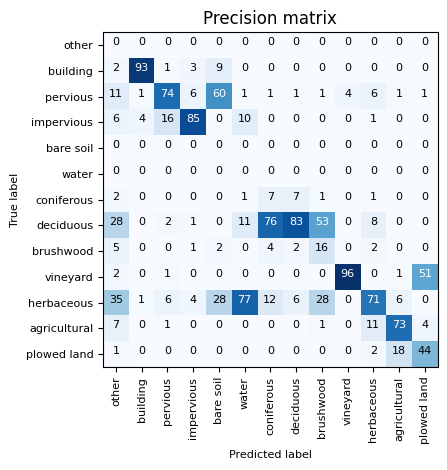

In [20]:
%matplotlib inline

from dl_toolbox.utils import plot_confusion_matrix

fig = plot_confusion_matrix(
    conf_mat,
    [c.name for c in classes],
    'precision'
)

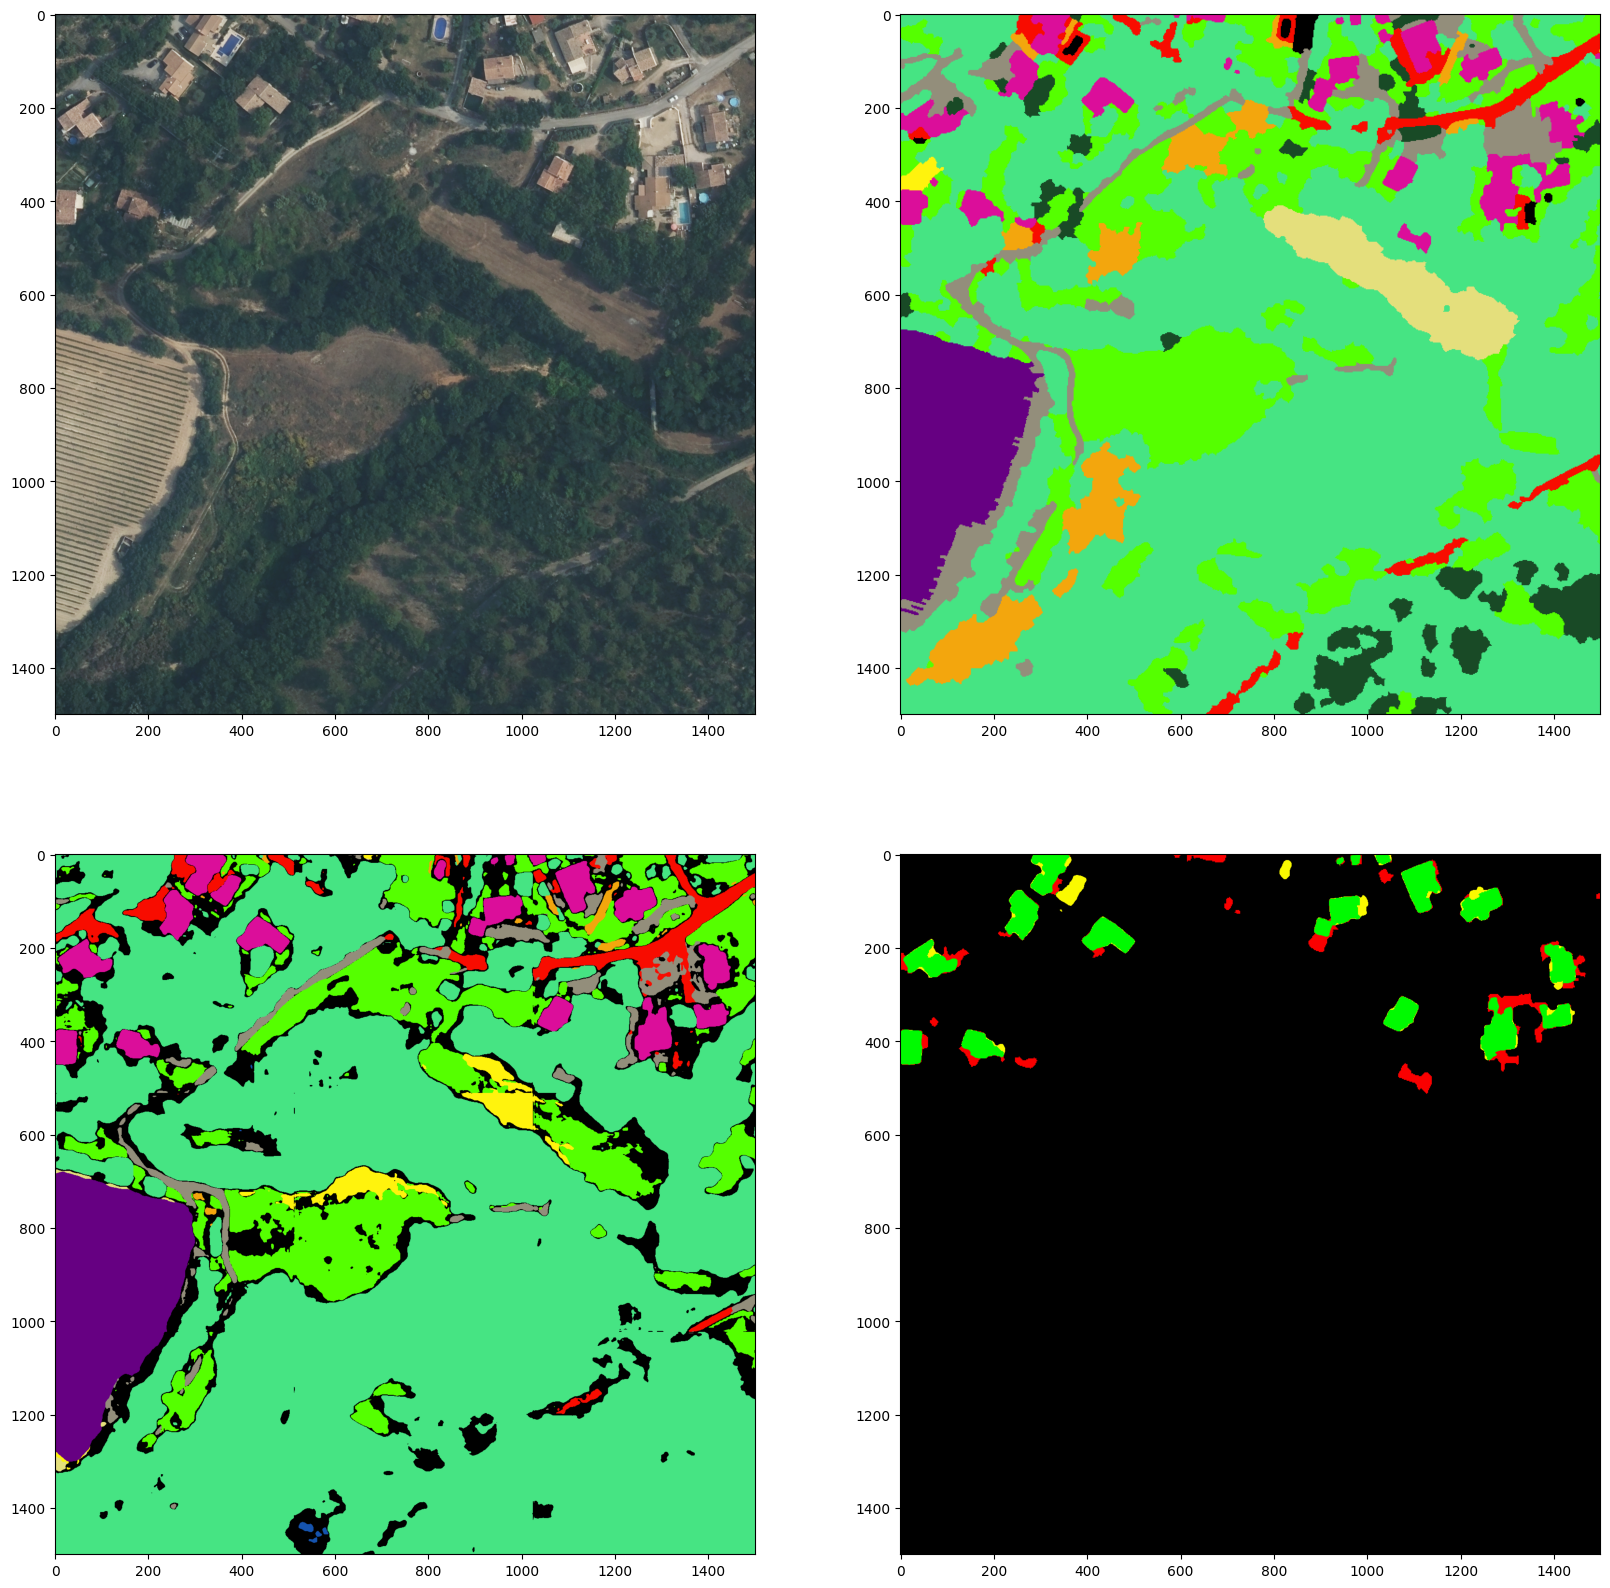

In [29]:
%matplotlib inline
import matplotlib.pyplot as plt 
from dl_toolbox.utils import labels_to_rgb

colors = [(i, c.color) for i, c in enumerate(classes)]

pred = preds.squeeze()
imagenp = image.numpy().transpose(1,2,0)[...,:3]

overlay = np.zeros(shape=(*preds.squeeze().shape, 3), dtype=np.uint8)
label_bool = label == 1
pred_bool = pred == 1

# Correct predictions (Hits) painted with green
overlay[label_bool & pred_bool] = np.array([0, 250, 0], dtype=overlay.dtype)
# Misses painted with red
overlay[label_bool & ~pred_bool] = np.array([250, 0, 0], dtype=overlay.dtype)
# False alarm painted with yellow
overlay[~label_bool & pred_bool] = np.array([250, 250, 0], dtype=overlay.dtype)

zone = np.s_[0:1500, 0:1500, ...]

fig = plt.figure(figsize=(20,20))
ax1 = fig.add_subplot(221)
ax1.imshow(imagenp[zone])
ax2 = fig.add_subplot(222)
ax2.imshow(labels_to_rgb(label, colors)[zone])
ax3 = fig.add_subplot(223)
ax3.imshow(labels_to_rgb(pred, colors)[zone])
ax4 = fig.add_subplot(224)
ax4.imshow(overlay[zone])